In [1]:
using DataFrames
using Plots

In [2]:
# O(Nlog(N)) with sort
function distribution(X,p)
    d = DataFrame(X = X, p = p)
    d = d[d.p .> 0,:]
    d = combine(groupby(d, ["X"]),df -> DataFrame(p = sum(df.p)) ) 
    sort!(d,["X"]) 
    return d
end

# This delta function is the inverse of cumsum
function delta(V)
    return [V[1];V[Not(1)]-V[Not(length(V))]]
end
            
function neat_CVaR(d,α) # O(N)
    if α == 0
        return minimum(d[d.p .> 0,:].X)
    else
        return (transpose(d.ΔX)*max.(zeros(nrow(d)),α .- d.Psum .+ d.p))/α
    end
end

# CVaR method to solve for multiple Alphas
function neat_CVaR_Vec(d,Alpha)
    d.ΔX = delta(d.X)      # O(N)
    d.Psum = cumsum(d.p)   # O(N)
    return [neat_CVaR(d,α) for α in Alpha]
end
                        
function CVaR2Distribution( cvar , λ ; sig = 10)
    p = delta( λ )
    X = round.( delta( λ .* cvar ) ./ (p) ;sigdigits = sig)
    d = distribution(X,p)
    return d
end

CVaR2Distribution (generic function with 1 method)

In [3]:
s1a1 = DataFrame(X = [-300,300], p = [0.25,0.75])
s1a2 = DataFrame(X = [0], p = [1.0])
s1a3 = DataFrame(X = [-50,250], p = [0.5,0.5])
s2 = DataFrame(X = [100], p = [1.0])

Alpha = LinRange(0,1,1001)
s1a1CVaR = neat_CVaR_Vec(s1a1,Alpha);
s1a2CVaR = neat_CVaR_Vec(s1a2,Alpha);
s1a3CVaR = neat_CVaR_Vec(s1a3,Alpha);
s1optCVaR = max.(s1a1CVaR,s1a2CVaR,s1a3CVaR);
s1opt = CVaR2Distribution( s1optCVaR , Alpha);

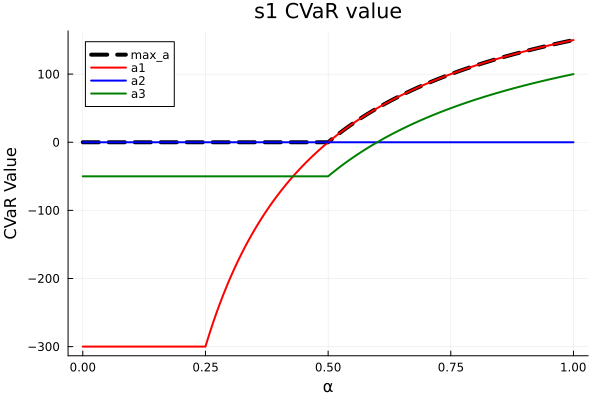

In [4]:
plot(
    Alpha,
    [s1optCVaR s1a1CVaR s1a2CVaR s1a3CVaR],
    title="s1 CVaR value",
    label=["max_a" "a1" "a2" "a3"],
    linestyle = [:dash :solid :solid :solid],
    lc = ["black" "red" "blue" "green"],
    linewidth=[ 4 2 2 2 ])
ylabel!("CVaR Value")
xlabel!("α")

In [5]:
jointopt = distribution([s1opt.X;s2.X],[s1opt.p .* 0.5;s2.p .* 0.5])
jointa1 = distribution([s1a1.X;s2.X],[s1a1.p .* 0.5;s2.p .* 0.5])
jointa2 = distribution([s1a2.X;s2.X],[s1a2.p .* 0.5;s2.p .* 0.5])
jointa3 = distribution([s1a3.X;s2.X],[s1a3.p .* 0.5;s2.p .* 0.5])
jointExpectedCVaR = neat_CVaR_Vec(jointopt,Alpha);
jointa1CVaR = neat_CVaR_Vec(jointa1,Alpha);
jointa2CVaR = neat_CVaR_Vec(jointa2,Alpha);
jointa3CVaR = neat_CVaR_Vec(jointa3,Alpha);
jointoptCVaR = max.(jointa1CVaR,jointa2CVaR,jointa3CVaR);
jointPerformCVaR = max.(jointa1CVaR,jointa2CVaR);

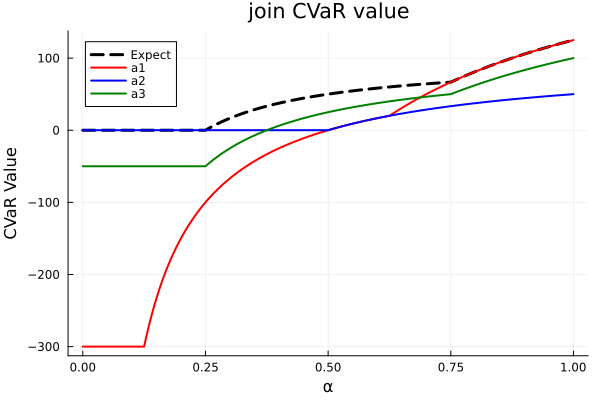

In [6]:
plot(
    Alpha,
    [jointExpectedCVaR jointa1CVaR jointa2CVaR jointa3CVaR],
    title="join CVaR value", label=["Expect" "a1" "a2" "a3"], 
    linestyle = [:dash :solid :solid :solid],
    lc = ["black" "red" "blue" "green"],
    linewidth=[ 3 2 2 2 ])
ylabel!("CVaR Value")
xlabel!("α")

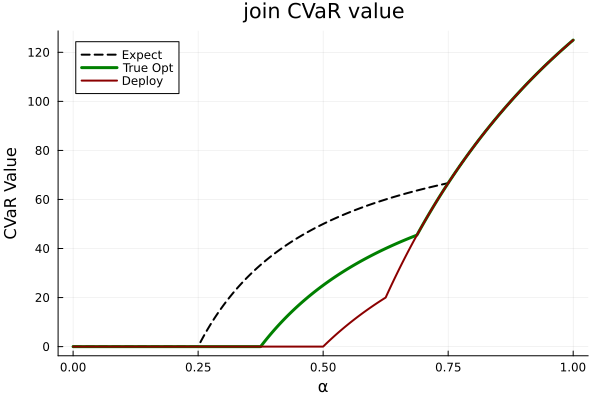

In [7]:
plot(
    Alpha,
    [jointExpectedCVaR jointoptCVaR jointPerformCVaR],
    title="join CVaR value", 
    linestyle = [:dash :solid :solid],
    label=["Expect" "True Opt" "Deploy"], 
    lc = ["black" "green" "darkred"], 
    linewidth=[ 2 3 2 ])
ylabel!("CVaR Value")
xlabel!("α")

In [8]:
Z = LinRange(0,1,10001)
Za1 = max.(100 .- 400 .* Z, -50 .+ 200 .* Z)
Za2 = 100 .- 100 .* Z
Za3 = max.( 100 .- 150 .* Z , -50 .+ 150 .* Z)
Zexp = max.(Za1,Za2,Za3)

expI = argmin(Zexp)
expVal = minimum(Zexp)

trueI = argmin(Za3)
trueVal = minimum(Za3);

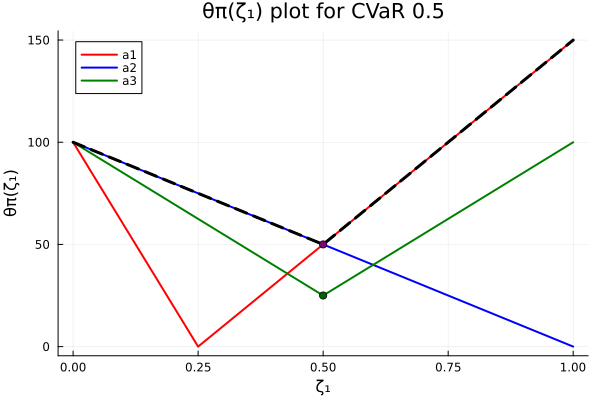

In [9]:
plot(
    Z,
    [Za1 Za2 Za3 Zexp],
    title="θπ(ζ₁) plot for CVaR 0.5", 
    label=["a1" "a2" "a3" ""], 
    linestyle = [:solid :solid :solid :dash ],
    lc = ["red" "blue" "green" "black"], 
    linewidth=[ 2 2 2 3 ])
ylabel!("θπ(ζ₁)")
xlabel!("ζ₁")
plot!([Z[expI]], [expVal], seriestype=:scatter,color="purple",label="")
plot!([Z[trueI]], [trueVal], seriestype=:scatter,color="darkgreen",label="")

For CVaR 50% in this case the the algorithm would gives us the purple value $50$ for either a1 or a2. However, the true optimal action a3 has a value of $25$. When one deploy the action suggested by the algorithm then they would receive $0$ instead of $25$ as their CVaR50%.